In [30]:
from torchvision.datasets import Cityscapes
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torch.nn as nn

In [31]:

valid_classes = [0,85, 170]
class_names = ["Background","Pupil","Iris"]


class_map = dict(zip(valid_classes, range(len(valid_classes))))
n_classes=len(valid_classes)
class_map

{0: 0, 85: 1, 170: 2}

In [32]:
colors = [ [  0,   0,   0],[0,255,0],[0,0,255]]
label_colours = dict(zip(range(n_classes), colors))

label_colours


{0: [0, 0, 0], 1: [0, 255, 0], 2: [0, 0, 255]}

In [33]:
def encode_segmap(mask):
    for _validc in valid_classes:
        mask[mask == _validc] = class_map[_validc]
    return mask

In [34]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colours[l][0]
        g[temp == l] = label_colours[l][1]
        b[temp == l] = label_colours[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [63]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
train_transform=A.Compose(
[
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

val_transform=A.Compose(
[
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)

In [36]:
from torch.utils.data import Dataset
from PIL import  Image


In [37]:
class Iris(Dataset):
    def __init__(self,x,y,transform=None):
        self.images_dir = x
        self.masks_dir = y
        self.transform = transform
    def __getitem__(self,index):
        image = Image.open(self.images_dir[index]).convert("RGB")
        mask = Image.open(self.masks_dir[index])
        
        if self.transform is not None:
            transformed =  transform(image = np.array(image),mask = np.array(mask))
        return transformed["image"],transformed["mask"]
    
    def __len__(self):
        return len(self.images_dir)

In [38]:
from glob import glob
train_images = "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/train_img/"
train_masks  = "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/train_masks/"


val_images = "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/val_img"

val_masks =  "/home/nipun/Documents/Uni_Malta/Datasets/Datasets/Miche/MICHE_MULTICLASS/Dataset/val_masks/" 


train_x = sorted(
        glob(f"{train_images}/*"))
train_y = sorted(
        glob(f"{train_masks}/*"))
valid_x = sorted(
        glob(f"{val_images}/*"))
valid_y = sorted(
        glob(f"{val_masks }/*"))

In [39]:
train_dataset = Iris(train_x,train_y,transform)
image,seg = train_dataset[20]

print(image.shape)
print(seg.shape)

torch.Size([3, 512, 512])
torch.Size([512, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


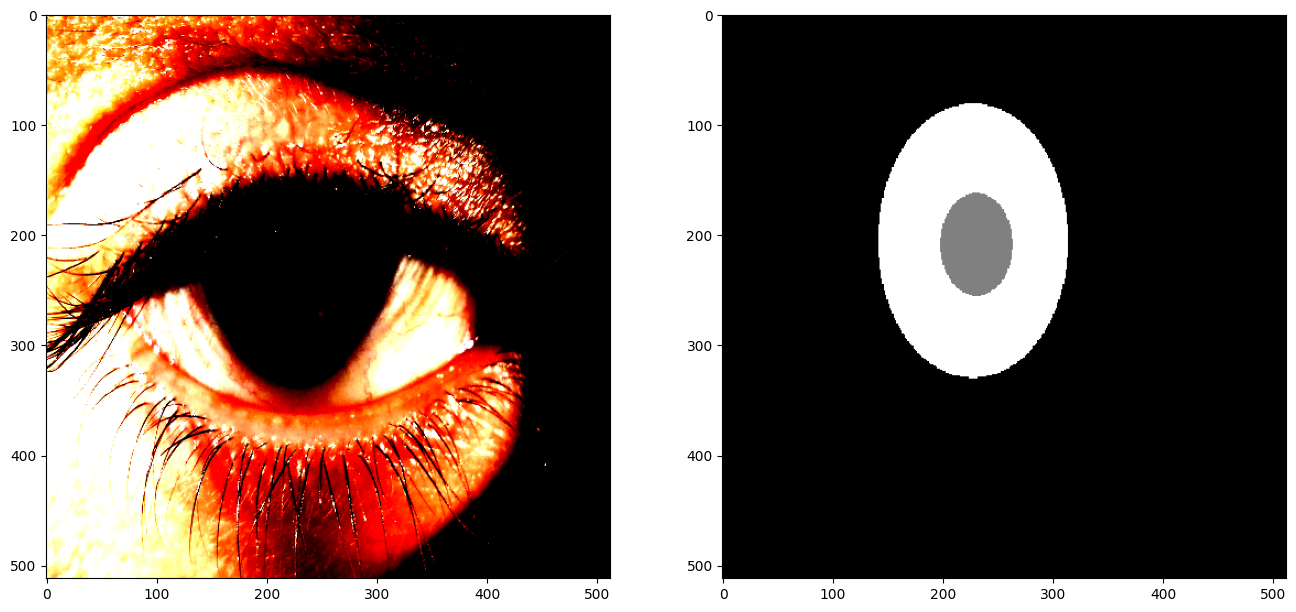

In [40]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(image.permute(1,2,0))
ax[1].imshow(seg,cmap="gray")

In [41]:
print(torch.unique(seg))
print(len(torch.unique(seg)))

tensor([  0,  85, 170], dtype=torch.uint8)
3


In [43]:
res = encode_segmap(seg.clone())

print(res.shape)
print(torch.unique(res))
print(len(torch.unique(res)))

torch.Size([512, 512])
tensor([0, 1, 2], dtype=torch.uint8)
3


In [44]:
res_1 = decode_segmap(res.clone())


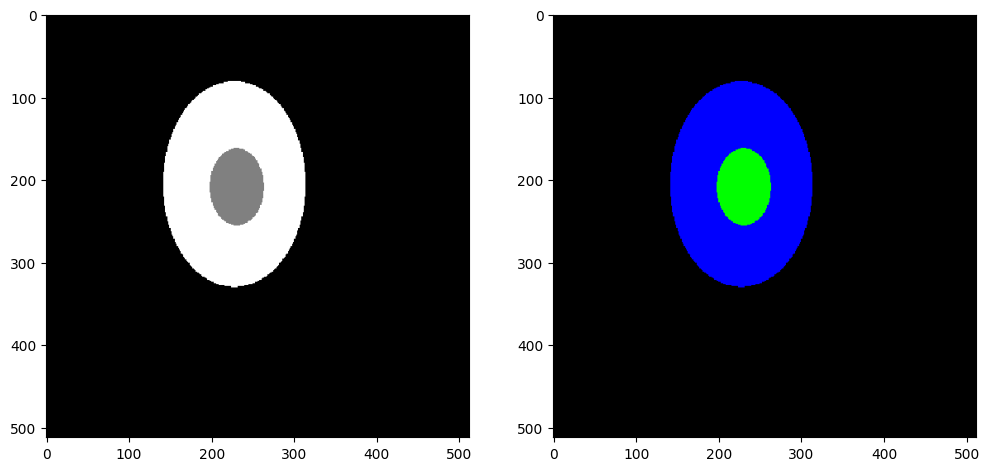

In [46]:
fig,ax=plt.subplots(ncols=2,figsize=(12,10))  
ax[0].imshow(res,cmap='gray')
ax[1].imshow(res_1)

In [60]:
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import segmentation_models_pytorch as smp
from pytorch_lightning import seed_everything,LightningModule,Trainer
import multiprocessing
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
import torch

In [ ]:
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel, self).__init__()
        self.layer = smp.Unet(encoder_name="resnet34",
                              encoder_weights="imagenet",
                              in_channels = 3,
                              classes=n_classes
                              )
        
        self.lr = 1e-3
        self.batch_size = 4
        self.numworker = multiprocessing.cpu_count()//4
        self.criterion = smp.losses.DiceLoss(mode = "multiclass")
        self.metrics = MulticlassJaccardIndex(num_classes=n_classes)
        
        
        self.train_cls = Iris(train_x,train_y,transform=train_transform)
        self.val_cls = Iris(valid_x,valid_y,transform=val_transform)
        
    def process(self,image,segment):
        out = self(image)
        segment = encode_segmap(segment)
        loss = self.criterion(out,segment.long())
        iou = self.metrics(out,segment)
        return loss,iou
    
    def forward(self,x):
        return self.layer(x)
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(),lr=self.lr)
        return opt
    
    def train_dataloader(self):
        return DataLoader(self.train_cls,batch_size=self
                          .batch_size,shuffle=False,num_workers=self.numworker,
                          pin_memory=True)
    def training_step(self,batch,batch_idx):
        image,segment = batch
        loss,iou = self.process(image,segment)
        self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
        self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        return loss
        
    def val_dataloader(self):
        return DataLoader(self.val_cls, batch_size=self.batch_size, 
                        shuffle=False,num_workers=self.numworker,pin_memory=True)
        
    def validation_step(self,batch,batch_idx):
        image,segment=batch
        loss,iou=self.process(image,segment)
        self.log('val_loss', loss,on_step=False, on_epoch=True,prog_bar=False)
        self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        return loss
        

In [83]:
model = OurModel()
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='checkpoints',
                                        filename='file',save_last=True)

In [84]:
trainer = Trainer(max_epochs=200, auto_lr_find=False, auto_scale_batch_size=False,
                  gpus=-1,precision=16,
                  callbacks=[checkpoint_callback],
                 )

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [70]:
train_cls = Iris(train_x,train_y,transform=train_transform)
val_cls = Iris(valid_x,valid_y,transform=val_transform)

In [72]:
img,seg = train_cls[20]
print(img.shape)
print(seg.shape)

torch.Size([3, 512, 512])
torch.Size([512, 512])


In [73]:
img,seg = val_cls[20]
print(img.shape)
print(seg.shape)

torch.Size([3, 512, 512])
torch.Size([512, 512])
